In [2]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [3]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")

In [4]:
df = pd.read_csv(os.getcwd()+r"\Data Files\recent_delinquency_small.csv")

In [5]:
df.head()

,MONTH_PAY,CUS_LAT,CUS_LONG,GRID_ID,DEFAULT_FLAG_CHANGE,NO_PAYMENT_CURRENT_PAYMENT
0,01-01-19,27.167417,78.039756,500_01998_04345,0,0
1,01-01-19,21.159421,72.798740,500_00912_03074,0,0
2,01-01-19,26.695748,75.644084,500_01529_04253,0,0
3,01-01-19,28.504803,77.242518,500_01848_04638,0,0
4,01-01-19,18.391716,73.627129,500_01053_02464,0,0


In [6]:
df.MONTH_PAY.value_counts()

01-02-19    723886
01-04-19    711038
01-06-19    698123
01-05-19    696816
01-08-19    692535
01-09-19    687987
01-07-19    685901
01-01-19    684146
01-03-19    683003
01-10-19    681127
01-11-19    674997
01-12-19    662698
Name: MONTH_PAY, dtype: int64

In [7]:
df["MONTH_PAY"] = pd.to_datetime(df["MONTH_PAY"], format="%d-%m-%y")

In [8]:
df_summ = df[["DEFAULT_FLAG_CHANGE","MONTH_PAY"]].groupby("MONTH_PAY").aggregate(["count","sum"])["DEFAULT_FLAG_CHANGE"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

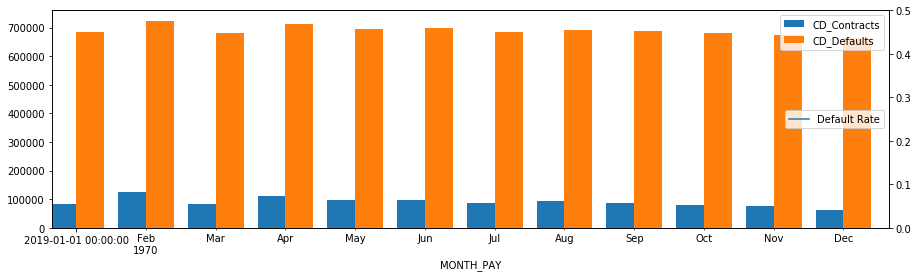

In [9]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.50)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [10]:
df_summ = df[["NO_PAYMENT_CURRENT_PAYMENT","MONTH_PAY"]].groupby("MONTH_PAY").aggregate(["count","sum"])["NO_PAYMENT_CURRENT_PAYMENT"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

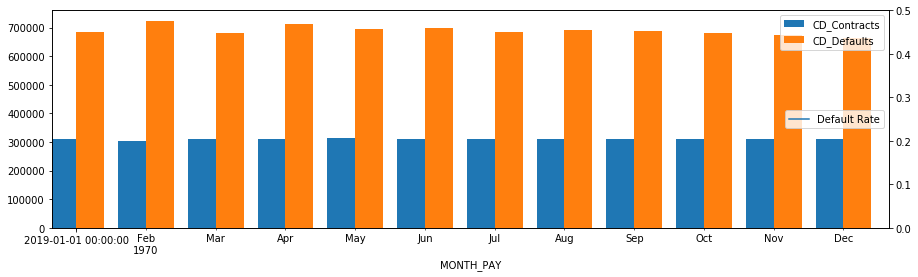

In [11]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.50)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


# "DEFAULT_FLAG_CHANGE"  Model (2 month data in training)

In [21]:
target = "DEFAULT_FLAG_CHANGE"

In [22]:
# Split Train and Test Data Set
df_train = df[(df["MONTH_PAY"]>=datetime.datetime(2019, 3, 1)) & 
              (df["MONTH_PAY"]<=datetime.datetime(2019, 5, 31))]
df_test = df[(df["MONTH_PAY"]>=datetime.datetime(2019, 6, 1)) & 
               (df["MONTH_PAY"]<=datetime.datetime(2019, 6, 30))]

In [23]:
print(df_train.shape)
print(df_test.shape)
print(df_train[target].value_counts())

(2090857, 6)
(698123, 6)
0    1800000
1     290857
Name: DEFAULT_FLAG_CHANGE, dtype: int64


In [24]:
#Downsampling Code 
#count_class_0, count_class_1 = df_train.RISK_FPD10.value_counts()
count_class_0, count_class_1 = (400000,400000)
df_class_0 = df_train[df_train[target] == 0]
df_class_1 = df_train[df_train[target] == 1]
df_class_0_under = df_class_0.sample(count_class_0, random_state = 2)
df_class_1_under = df_class_1.sample(count_class_1, random_state = 2)
df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

print('Random under-sampling:')
print(df_train_under[target].value_counts())

df_train_under[target].value_counts().plot(kind='bar', title='Count (target)');

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
X_test = df_test[["CUS_LAT","CUS_LONG"]]

y_train = df_train_under[target]
y_test =  df_test[target]


In [25]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))


Event rate in train set : 50.00%

Event rate in test set : 14.06%


In [26]:
param_grid = {'n_neighbors': np.arange(1,500,5)
            }
seed = 25

In [27]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(weights = 'uniform')
kfolds = StratifiedKFold(4, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=20,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [28]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


KeyboardInterrupt: 

In [272]:
dic

{'mean_fit_time': array([0.90501943, 1.0391911 , 0.37988415, 0.42057486, 0.40606565,
        0.34720607, 0.38721724, 0.39726968, 0.38066564, 0.37236495,
        0.30806408, 0.33778276, 0.34869695, 0.33939576, 0.33963265,
        0.35193729, 0.35767202, 0.33744283, 0.33765826, 0.34109564,
        0.34563317, 0.32525954, 0.31496081, 0.31830173, 0.33775806,
        0.31906233, 0.34402609, 0.35876455, 0.32382183, 0.34326448]),
 'std_fit_time': array([0.04862649, 0.25002636, 0.01620935, 0.03584943, 0.05290023,
        0.01159257, 0.02183368, 0.01543541, 0.03543233, 0.03716962,
        0.02294258, 0.02115058, 0.0226904 , 0.01589204, 0.01760229,
        0.01340393, 0.01125206, 0.01814277, 0.02195947, 0.01426053,
        0.01410303, 0.01221015, 0.01769849, 0.01287955, 0.02160025,
        0.01204591, 0.02099102, 0.01474673, 0.01484425, 0.01321252]),
 'mean_score_time': array([16.21761842, 12.55109162,  6.43050485, 12.38240561, 13.94588366,
         1.33342171, 10.95964899, 16.80211802, 15.85257

In [269]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\EMI Payments Trends_RCV_results_FPD10.csv")

In [270]:
tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')

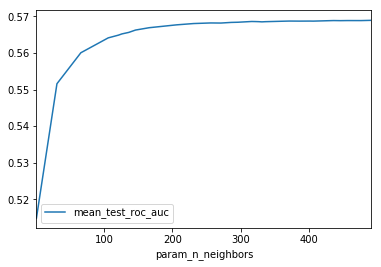

In [271]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors")

In [238]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]]

,param_n_neighbors,mean_test_roc_auc
3,1,0.529068
7,31,0.568349
1,66,0.574208
6,186,0.578958
8,191,0.578968
9,256,0.579534
2,266,0.579566
0,271,0.579587
5,291,0.579715
4,351,0.579827


In [239]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5798272527812501
Best params: 
n_neighbors: 351


In [29]:
#update estimated hyperparameter values to new model
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': 350}
kfolds = StratifiedKFold(4, random_state=1)
knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [30]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [31]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1

In [32]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

GINI TRAIN: 18.40%

GINI TEST: 17.30%

GINI CV: 15.88%


In [33]:
df1= pd.read_csv(os.getcwd()+r"\Data Files\final_grids.csv")

In [34]:
df1["TIME_DECISION_DATE"] = pd.to_datetime(df1["TIME_DECISION_DATE"],format="%d-%m-%y")

In [35]:
df1_test=df1[(df1["TIME_DECISION_DATE"]>=datetime.datetime(2019,6,1)) & (df1["TIME_DECISION_DATE"]<=datetime.datetime(2019,6,30))]


In [36]:
df1_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE
10847834,237941809,2019-06-01,10.128995,76.380272,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01579_00624,0.050372
10847835,237941812,2019-06-01,18.477572,74.020281,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01136_02479,0.031215
10847836,237941815,2019-06-01,25.280738,82.998425,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_02972_03938,0.119862
10847837,237941816,2019-06-01,30.561420,76.758889,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01766_05090,0.030451
10847838,237941818,2019-06-01,30.815237,76.346362,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01689_05147,0.033898


In [37]:
ypred_test = bst.predict_proba(df1_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [38]:
print(2*metrics.roc_auc_score(df1_test["RISK_FPD30"],ypred_test)-1)
print(2*metrics.roc_auc_score(df1_test["RISK_FSPD30"],ypred_test)-1)
print(2*metrics.roc_auc_score(df1_test["RISK_FSTPD30"],ypred_test)-1)
print(2*metrics.roc_auc_score(df1_test["RISK_FSTQPD30"],ypred_test)-1)
print(2*metrics.roc_auc_score(df1_test["RISK_FSTQPD60"],ypred_test)-1)


0.009570104562319104
0.015473439934393651
0.027763163219940434
0.048184822576784914
0.034615065861429706


In [250]:
df1_test["YPRED"] = ypred_test

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [251]:
dates=df1_test.TIME_DECISION_DATE.unique()

dates.sort()

dict1 = {"x":[],"gini":[]}

for x in dates:
    print(x, 2*metrics.roc_auc_score(df1_test[df1_test["TIME_DECISION_DATE"]==x]["RISK_FSTQPD30"],
                                     df1_test[df1_test["TIME_DECISION_DATE"]==x]["YPRED"])-1)
    dict1["x"].append(x)
    dict1["gini"].append(2*metrics.roc_auc_score(df1_test[df1_test["TIME_DECISION_DATE"]==x]["RISK_FSTQPD30"],
                                     df1_test[df1_test["TIME_DECISION_DATE"]==x]["YPRED"])-1)
    
gini_df = pd.DataFrame(dict1)    

2019-06-01T00:00:00.000000000 0.05733804742815396
2019-06-02T00:00:00.000000000 0.04377968715132541
2019-06-03T00:00:00.000000000 0.026002069819618612
2019-06-04T00:00:00.000000000 0.06424221555760301
2019-06-05T00:00:00.000000000 0.0808770194526871
2019-06-06T00:00:00.000000000 -0.0012684369356268377
2019-06-07T00:00:00.000000000 0.027152777710506948
2019-06-08T00:00:00.000000000 0.03979501317221468
2019-06-09T00:00:00.000000000 0.04554668822482877
2019-06-10T00:00:00.000000000 0.08019913517313393
2019-06-11T00:00:00.000000000 0.06537940296519218
2019-06-12T00:00:00.000000000 0.05592607354941537
2019-06-13T00:00:00.000000000 0.08950839077329209
2019-06-14T00:00:00.000000000 0.030307144392113683
2019-06-15T00:00:00.000000000 0.04180068730041153
2019-06-16T00:00:00.000000000 0.07510383616585758
2019-06-17T00:00:00.000000000 0.03906023719769647
2019-06-18T00:00:00.000000000 0.036103917457968704
2019-06-19T00:00:00.000000000 0.04718317882708645
2019-06-20T00:00:00.000000000 0.018398241038

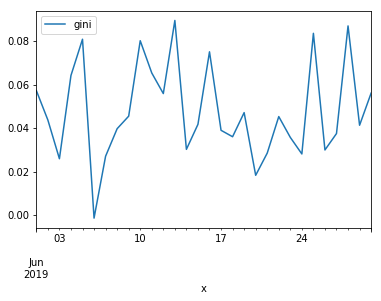

In [252]:
gini_df.plot(x="x",y="gini")

# "NO_PAYMENT_CURRENT_PAYMENT"  Model (2 month data in training)

In [258]:
target = "NO_PAYMENT_CURRENT_PAYMENT"

In [259]:
# Split Train and Test Data Set
df_train = df[(df["MONTH_PAY"]>=datetime.datetime(2019, 5, 1)) & 
              (df["MONTH_PAY"]<=datetime.datetime(2019, 5, 31))]
df_test = df[(df["MONTH_PAY"]>=datetime.datetime(2019, 6, 1)) & 
               (df["MONTH_PAY"]<=datetime.datetime(2019, 6, 30))]

In [260]:
print(df_train.shape)
print(df_test.shape)
print(df_train[target].value_counts())

(696816, 6)
(698123, 6)
0    382539
1    314277
Name: NO_PAYMENT_CURRENT_PAYMENT, dtype: int64


Random under-sampling:
1    300000
0    300000
Name: NO_PAYMENT_CURRENT_PAYMENT, dtype: int64


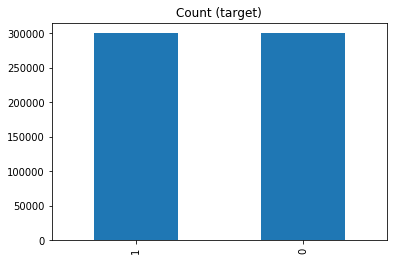

In [263]:
#Downsampling Code 
#count_class_0, count_class_1 = df_train.RISK_FPD10.value_counts()
count_class_0, count_class_1 = (300000,300000)
df_class_0 = df_train[df_train[target] == 0]
df_class_1 = df_train[df_train[target] == 1]
df_class_0_under = df_class_0.sample(count_class_0, random_state = 2)
df_class_1_under = df_class_1.sample(count_class_1, random_state = 2)
df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

print('Random under-sampling:')
print(df_train_under[target].value_counts())

df_train_under[target].value_counts().plot(kind='bar', title='Count (target)');

In [264]:
X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
X_test = df_test[["CUS_LAT","CUS_LONG"]]

y_train = df_train_under[target]
y_test =  df_test[target]


In [265]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))


Event rate in train set : 50.00%

Event rate in test set : 44.41%


In [266]:
param_grid = {'n_neighbors': np.arange(1,500,5)
            }
seed = 25

In [129]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(weights = 'uniform')
kfolds = StratifiedKFold(4, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=10,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [44]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..
Randomized search time: 1037.6989278793335


In [45]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\EMI Payments Trends_RCV_results_NO_PAYMENT.csv")

In [46]:
tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')

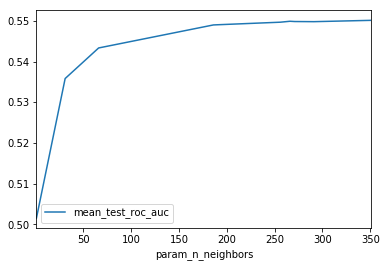

In [47]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors")

In [48]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]]

,param_n_neighbors,mean_test_roc_auc
3,1,0.501550
7,31,0.535827
1,66,0.543341
6,186,0.548998
8,191,0.549050
9,256,0.549674
2,266,0.549902
0,271,0.549837
5,291,0.549804
4,351,0.550130


In [49]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.55012985625
Best params: 
n_neighbors: 351


In [130]:
#update estimated hyperparameter values to new model
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': 351}
kfolds = StratifiedKFold(4, random_state=1)
knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [131]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [132]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1

In [133]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

GINI TRAIN: 15.89%

GINI TEST: 14.13%

GINI CV: 13.43%


In [40]:
#df1= pd.read_pickle(os.getcwd()+r"\Data Files\concated.pkl")

In [134]:
df1.head()

,Unnamed: 0,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,RISK_SCORE,MONTH_STR
0,0,273217442,2019-09-15,26.925771,75.823658,0.0,0.0,0.0,0.0,0.0,0.0,NTC,0.164707,2019-09
1,1,273217520,2019-09-15,28.704617,77.046645,0.0,0.0,0.0,0.0,0.0,0.0,NTC,0.111792,2019-09
2,2,273217523,2019-09-15,11.089342,77.336750,0.0,0.0,0.0,0.0,0.0,0.0,NTC,0.111993,2019-09
3,3,273217525,2019-09-15,19.179927,73.028721,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.018660,2019-09
4,4,273217526,2019-09-15,12.917143,80.192349,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.049166,2019-09


In [135]:
df1_test=df1[(df1["TIME_DECISION_DATE"]>=datetime.datetime(2019,6,1)) & (df1["TIME_DECISION_DATE"]<=datetime.datetime(2019,6,30))]


In [136]:
ypred_test = bst.predict_proba(df1_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [137]:
print(2*metrics.roc_auc_score(df1_test["RISK_FPD30"],ypred_test)-1)
print(2*metrics.roc_auc_score(df1_test["RISK_FSPD30"],ypred_test)-1)
print(2*metrics.roc_auc_score(df1_test["RISK_FSTPD30"],ypred_test)-1)
print(2*metrics.roc_auc_score(df1_test["RISK_FSTQPD30"],ypred_test)-1)
print(2*metrics.roc_auc_score(df1_test["RISK_FSTQPD60"],ypred_test)-1)


0.07198497158785755
0.061296111352883376
0.05680283465435321
0.06447809648638558
0.08274870165350379


In [138]:
df1_test["YPRED"] = ypred_test

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [94]:
dates=df1_test.TIME_DECISION_DATE.unique()

dates.sort()

dict1 = {"x":[],"gini":[]}

for x in dates:
    print(x, 2*metrics.roc_auc_score(df1_test[df1_test["TIME_DECISION_DATE"]==x]["RISK_FSTQPD30"],
                                     df1_test[df1_test["TIME_DECISION_DATE"]==x]["YPRED"])-1)
    dict1["x"].append(x)
    dict1["gini"].append(2*metrics.roc_auc_score(df1_test[df1_test["TIME_DECISION_DATE"]==x]["RISK_FSTQPD30"],
                                     df1_test[df1_test["TIME_DECISION_DATE"]==x]["YPRED"])-1)
    
gini_df = pd.DataFrame(dict1)    

2019-06-01T00:00:00.000000000 0.08468155637795571
2019-06-02T00:00:00.000000000 0.09609283112446665
2019-06-03T00:00:00.000000000 0.063185236330501
2019-06-04T00:00:00.000000000 0.05484776620348608
2019-06-05T00:00:00.000000000 0.09943314794095559
2019-06-06T00:00:00.000000000 0.04391574392227415
2019-06-07T00:00:00.000000000 0.053611643089038985
2019-06-08T00:00:00.000000000 0.08182679945006588
2019-06-09T00:00:00.000000000 0.050607254073402386
2019-06-10T00:00:00.000000000 0.09908089464633685
2019-06-11T00:00:00.000000000 0.08387812091216751
2019-06-12T00:00:00.000000000 0.08963151176164597
2019-06-13T00:00:00.000000000 0.06465745532253653
2019-06-14T00:00:00.000000000 0.03516591751580389
2019-06-15T00:00:00.000000000 0.07905440270903052
2019-06-16T00:00:00.000000000 0.08028776895762824
2019-06-17T00:00:00.000000000 0.061297056724372245
2019-06-18T00:00:00.000000000 0.09830252622828795
2019-06-19T00:00:00.000000000 0.05384306500377933
2019-06-20T00:00:00.000000000 0.07232214909094226

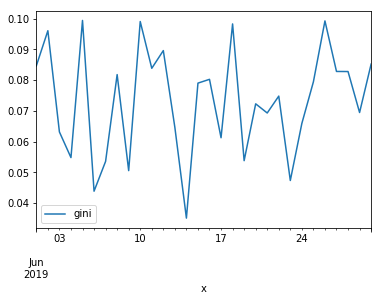

In [97]:
gini_df.plot(x="x",y="gini")